<a href="https://colab.research.google.com/github/orinizri/ML_AI_colab_notebooks/blob/main/LeNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install torch
# !pip3 install torchvision

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def image_convert(tensor):
    # Clone the tensor and detach it from the computation graph to avoid affecting gradients
    image = tensor.cpu().clone().detach().numpy()
    # Transpose from (C, H, W) to (H, W, C) to match standard image format
    image = image.transpose(1, 2, 0)
    # Denormalize the image (assuming it was normalized with mean=0.5 and std=0.5)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # Clip values to ensure they're between 0 and 1, as required for images
    image = np.clip(image, 0, 1)
    return image

classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')

In [ ]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

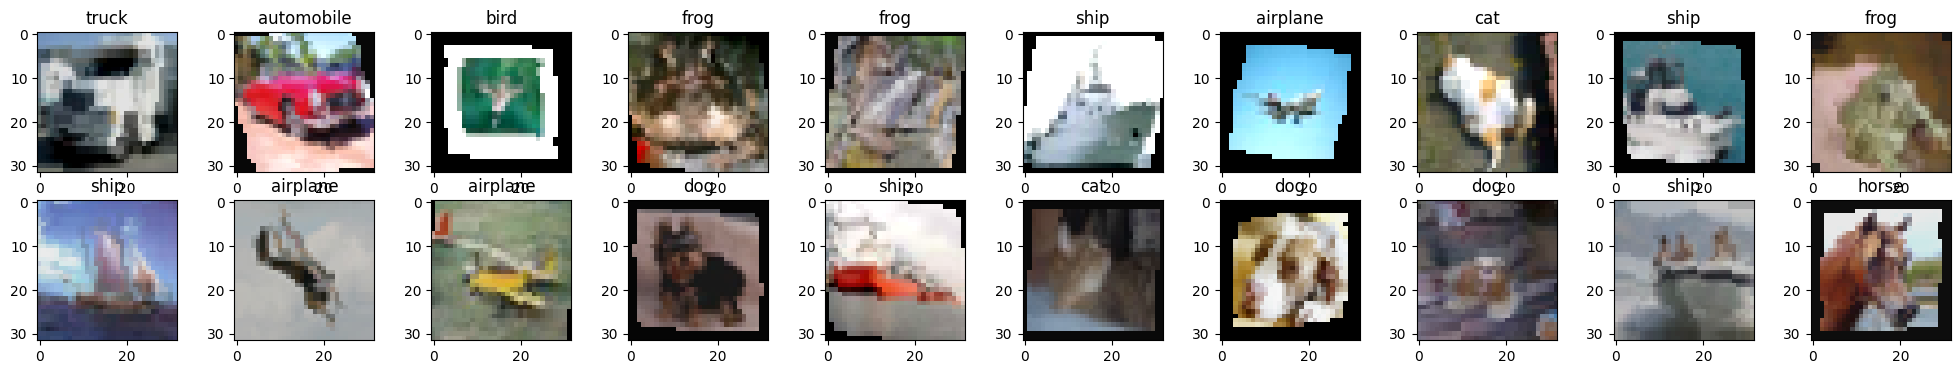

In [ ]:
data_iterator = iter(training_loader)
images, labels = next(data_iterator)
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title(classes[labels[i].item()])


In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in_channel, features, kernel size, stride
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [ ]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs
    labels = labels
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs
          val_labels = val_labels
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, labels)
          _, val_preds = torch.max(outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == labels.data)



    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch:', e + 1)
    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch: 1
training loss: 1.7012, accuracy: 37.8980
validation loss: 3.6217, accuracy: 48.0000
epoch: 2
training loss: 1.3970, accuracy: 49.5140
validation loss: 4.3595, accuracy: 46.0000
epoch: 3
training loss: 1.2633, accuracy: 54.9200
validation loss: 4.5146, accuracy: 51.0000
epoch: 4
training loss: 1.1749, accuracy: 58.4440
validation loss: 5.1815, accuracy: 60.0000
epoch: 5
training loss: 1.1097, accuracy: 60.8020
validation loss: 5.2488, accuracy: 61.0000
epoch: 6
training loss: 1.0570, accuracy: 62.5780
validation loss: 5.5678, accuracy: 65.0000
epoch: 7
training loss: 1.0138, accuracy: 64.5560
validation loss: 5.9555, accuracy: 65.0000
epoch: 8
training loss: 0.9853, accuracy: 65.4820
validation loss: 5.6533, accuracy: 66.0000
epoch: 9
training loss: 0.9516, accuracy: 66.8480
validation loss: 6.4684, accuracy: 62.0000
epoch: 10
training loss: 0.9299, accuracy: 67.2420
validation loss: 6.5697, accuracy: 65.0000
epoch: 11
training loss: 0.9131, accuracy: 68.0620
validation loss: 6

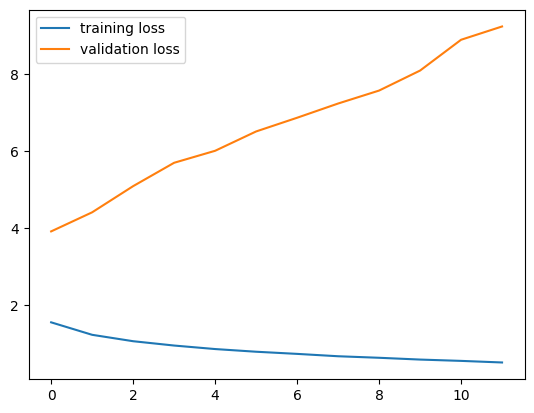

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

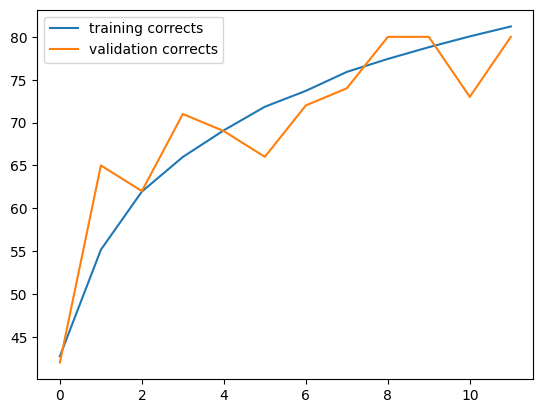

In [ ]:
running_corrects_history_Cpu = torch._to_cpu(running_corrects_history)
plt.plot(running_corrects_history, label='training corrects')
plt.plot(val_running_corrects_history, label='validation corrects')
plt.legend()

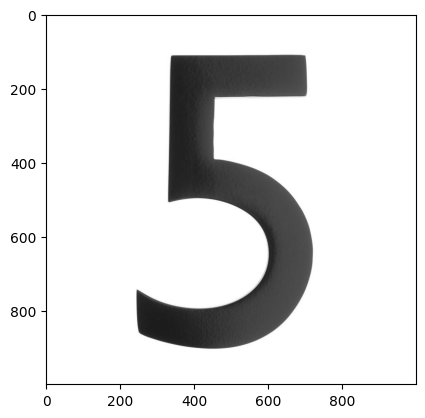

In [ ]:
import requests
from PIL import Image
import PIL

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

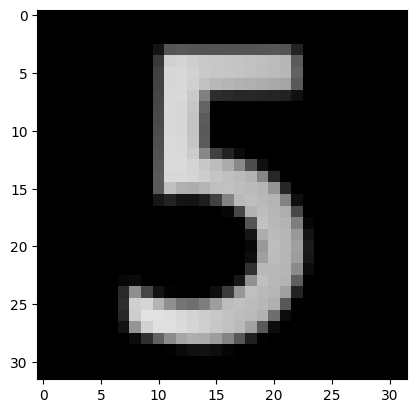

In [ ]:
# Preprocess black background and white number
img = PIL.ImageOps.invert(img)
img = transform(img)
plt.imshow(image_convert(img))

In [ ]:
images = img
output = model(images)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

automobile


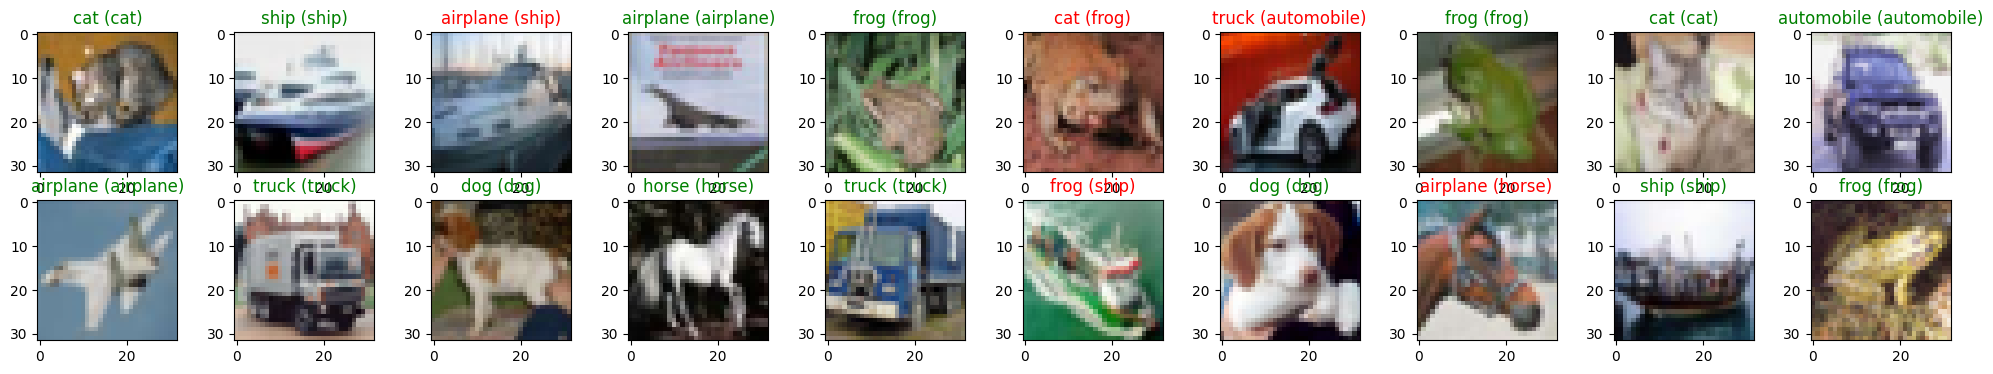

In [ ]:
data_iterator = iter(validation_loader)
images, labels = next(data_iterator)
images = images
labels = labels
fig = plt.figure(figsize=(25,4))
outputs = model(images)
_, preds = torch.max(outputs, 1)
for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title('{} ({})'.format(str(classes[preds[i].item()]), str(classes[labels[i].item()])), color=("green" if preds[i] == labels[i] else "red"))